# Programming Assignment 1: Predicting House Prices


In [55]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
torch.__version__
pd.__version__

'1.4.1'

#### Read the CSV into a pandas DataFrame

Using random_state, with a given DataFrame, the sample will always fetch same rows. If random_state is None or np.random, then a randomly-initialized RandomState object is returned.

In [56]:
df = pd.read_csv("data/home_data.csv")
# print(df)
# print(df['price'][0])
df.sample(n=3, random_state=0)

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
17384,1453602313,20141029T000000,297000,2,1.50,1430,1650,3.0,0,0,...,7,1430,0,1999,0,98125,47.7222,-122.290,1430,1650
722,2225059214,20140808T000000,1578000,4,3.25,4670,51836,2.0,0,0,...,12,4670,0,1988,0,98005,47.6350,-122.164,4230,41075
2680,2768000270,20140625T000000,562100,2,0.75,1440,3700,1.0,0,0,...,7,1200,240,1914,0,98107,47.6707,-122.364,1440,4300


#### Visualize the data

<AxesSubplot:xlabel='sqft_living', ylabel='price'>

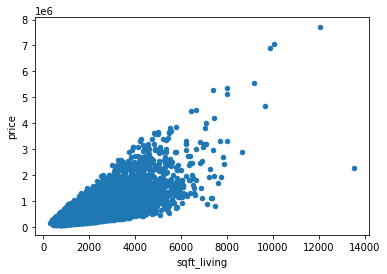

In [57]:
df.plot(kind='scatter', x='sqft_living', y='price')

#### Splitting the data into training and test sets

Use Scikit Learn's <code>train_test_split</code> to split dataframes.

When comparing machine learning algorithms, it's desirable that they are fit and evaluated on the same subsets of the dataset. This can be achieved by setting the <code>random_state</code> to an integer value. For more information, see [Repeatable Train-Test Splits](https://machinelearningmastery.com/train-test-split-for-evaluating-machine-learning-algorithms/).

In [58]:
train, test = train_test_split(df, test_size=0.2, random_state=1)
type(train)

pandas.core.frame.DataFrame

The mean price of our training set.

In [59]:
train['price'].mean()

537880.6155002891

### Prepare the data
We need the data as PyTorch tensors for usage in our model. We will need to convert pandas DataFrame to Numpy Array and then Pytorch Tensor. 

To convert a Pandas DataFrame to a Numpy Array, use <code>to_numpy()</code>. To convert a Numpy Array to a PyTorch Tensor, use <code>torch.from_numpy()</code>. For more information, see [this page](https://medium.com/@thackerhelik/linear-regression-in-pytorch-3793d89ff3f).

In [60]:
def df_to_array(dataframe, features, output=['price']):
    """
    Parameters
    ----------
    dataframe: pandas DataFrame
        train or test set
    features: list of strings
        features used to predict sales price of house
    output: list of strings
        the observation variable
    """
    df1 = dataframe.copy(deep=True)
    inputs_array = df1[features].to_numpy()
    targets_array = df1[output].to_numpy()
    return inputs_array, targets_array

inputs_array, targets_array = df_to_array(train, ['sqft_living'], ['price'])
targets_array
#inputs.dtype

array([[ 353000],
       [ 300523],
       [ 435000],
       ...,
       [ 650000],
       [ 437000],
       [1025000]], dtype=int64)

In [61]:
def arr_to_tensor(inputs_array, targets_array):
    """
    Parameters
    ----------
    inputs_array: numpy array
    targets_array: numpy array
    """
    inputs_train = torch.from_numpy(inputs_array).float()
    targets_train = torch.from_numpy(targets_array).float()
    return inputs_train, targets_train

inputs_train, targets_train = arr_to_tensor(inputs_array, targets_array)
inputs_train, targets_train

(tensor([[2190.],
         [2370.],
         [1230.],
         ...,
         [1970.],
         [1980.],
         [3760.]]),
 tensor([[ 353000.],
         [ 300523.],
         [ 435000.],
         ...,
         [ 650000.],
         [ 437000.],
         [1025000.]]))

In [62]:
#dataset = TensorDataset(inputs_train, targets_train)
#train_loader = DataLoader(dataset, batch_size=50, shuffle=False)
#for xb, yb in train_loader:
#    print("inputs:", xb)
#    print("targets:", yb)
#    break

#inputs = torch.from_numpy(train[['sqft_living']].to_numpy()).float() # Must be df[[feature]] to ensure 2D array
#inputs
#targets = torch.from_numpy(train[['price']].to_numpy()).float()
#targets
#targets.dtype
#train[['price']].to_numpy()

### Create a linear regression model
#### Define the regression class

In [63]:
class LinearRegression(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LinearRegression, self).__init__()
        self.linear = torch.nn.Linear(input_dim, output_dim, bias=True) # bias default True
        
    def forward(self, x):
        out = self.linear(x)
        return out

#### Instantiate model

In [64]:
input_dim = 1
output_dim = 1
model1 = LinearRegression(input_dim, output_dim)

#### Compute RMSE Loss
Compute RMSE instead of MSE for this task.

In [65]:
def RMSELoss(prediction, target):
    loss_function = nn.MSELoss()
    RMSE_loss = torch.sqrt(loss_function(prediction, target))
    return RMSE_loss

#### Optimizer

In [66]:
learningRate = 0.2 # Any small positive value between 0 and 1, try different learning rates
optimizer = torch.optim.SGD(model1.parameters(), lr=learningRate)

#### Training the model

In [67]:
def trainModel(model, x, y, epochs):
    for epoch in range(epochs):
        # Clear gradient buffers so that gradient from previous epoch is not carried to current one
        optimizer.zero_grad()
        
        # Output by model
        y_pred = model(x)
        
        RMSE_loss = RMSELoss(y_pred, y)
        # print(RMSE_loss)
        RMSE_loss.backward()
        
        # Updates the parameters
        optimizer.step()

        print('epoch {}, loss {}'.format(epoch, RMSE_loss.item()))
        
trainModel(model1, inputs_train, targets_train, 50)

epoch 0, loss 645831.25
epoch 1, loss 430447.09375
epoch 2, loss 542711.625
epoch 3, loss 495427.75
epoch 4, loss 520206.46875
epoch 5, loss 507835.875
epoch 6, loss 514203.5625
epoch 7, loss 510970.4375
epoch 8, loss 512624.4375
epoch 9, loss 511781.65625
epoch 10, loss 512211.84375
epoch 11, loss 511992.28125
epoch 12, loss 512104.03125
epoch 13, loss 512047.1875
epoch 14, loss 512076.4375
epoch 15, loss 512061.3125
epoch 16, loss 512069.4375
epoch 17, loss 512065.0625
epoch 18, loss 512067.25
epoch 19, loss 512066.0625
epoch 20, loss 512066.75
epoch 21, loss 512066.375
epoch 22, loss 512066.5
epoch 23, loss 512066.5
epoch 24, loss 512066.5
epoch 25, loss 512066.5
epoch 26, loss 512066.5
epoch 27, loss 512066.5
epoch 28, loss 512066.4375
epoch 29, loss 512066.5
epoch 30, loss 512066.4375
epoch 31, loss 512066.5
epoch 32, loss 512066.4375
epoch 33, loss 512066.53125
epoch 34, loss 512066.5625
epoch 35, loss 512066.40625
epoch 36, loss 512066.5625
epoch 37, loss 512066.40625
epoch 38, 

#### Model Parameters

In [68]:
for name, param in model1.named_parameters():
    if param.requires_grad:
        print(name, param.data)

linear.weight tensor([[64.9476]])
linear.bias tensor([-0.1582])


## Use other features in the data

In [69]:
features = ['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'zipcode']

inputs_array2, targets_array2 = df_to_array(train, features, ['price'])
#inputs_array2
#targets_array2

inputs_train2, targets_train2 = arr_to_tensor(inputs_array2, targets_array2)
#inputs_train2, targets_train2

model2 = LinearRegression(6, 1) # Input dimension = 6, output dimension = 1

lr2 = 0.00001 # Any small positive value between 0 and 1, try different learning rates
optimizer = torch.optim.SGD(model2.parameters(), lr=lr2)

trainModel(model2, inputs_train2, targets_train2, 10)

epoch 0, loss 640618.875
epoch 1, loss 573360.625
epoch 2, loss 513994.625
epoch 3, loss 464172.0625
epoch 4, loss 425077.5625
epoch 5, loss 396814.875
epoch 6, loss 378104.15625
epoch 7, loss 366681.21875
epoch 8, loss 360137.0625
epoch 9, loss 356546.375


## Tasks

### Task 1: Selection and Summary Statistics
One neighborhood of Seattle has the highest average house sale price. Note down the ZIP code of this neighborhood and compute the average price. *Save this result to answer the quiz at the end.*

In [70]:
zip_98039 = df['zipcode'] == 98039
df_98039 = df[zip_98039]
df_98039.head()
df_98039.shape

df_98039['price'].mean() # Mean price of houses in this neighborhood

2160606.6

### Task 2: Filtering Data
- Use logical filters to select rows of an SFrame.
- Using such filters, first select the houses that have 'sqft_living' higher than 2000 sqft but no larger than 4000 sqft.
- What fraction of the all houses have 'sqft_living' in this range? *Save this result to answer the quiz at the end.*


In [71]:
higher_than_2000 = df['sqft_living'] > 2000
less_than_4000 = df['sqft_living'] < 4000
df_ht2 = df[higher_than_2000]
df_filtered = df_ht2[less_than_4000]

df_filtered.head()
df_filtered.shape[0] # 9111 houses have sqft_living higher than 2000 sqft but no larger than 4000 sqft
df.shape[0] # 21613 houses in total
fraction = df_filtered.shape[0]/df.shape[0]
print(fraction) # 42.155% of all houses in the dataset have sqft_living in this range

0.4215518437977143


C:\Users\Administrator\AppData\Local\Temp\ipykernel_11268\555855110.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_filtered = df_ht2[less_than_4000]


### Task 3: Building the Model
Use the original dataset and build a model using the following features: bedrooms, bathrooms, sqft_living, sqft_lot, floors, zipcode, condition, grade, waterfront, view, sqft_above, sqft_basement, yr_built, yr_renovated, lat, long, sqft_living15, sqft_lot15.

Compute the RMSE (root mean squared error) on the test data for the model using basic features and advanced features.

Note:
- When doing the train-test split, make sure to use seed=0.
- RMSE is the square root of the mean RSS.

What is the difference in RMSE between the model trained with my_features and the one trained with advanced_features? *Save this result to answer the quiz at the end.*

In [72]:
my_features = ['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'zipcode']

In [73]:
advanced_features = [
'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'zipcode',
'condition', # condition of house
'grade', # measure of quality of construction
'waterfront', # waterfront property
'view', # type of view
'sqft_above', # square feet above ground
'sqft_basement', # square feet in basement
'yr_built', # the year built
'yr_renovated', # the year renovated
'lat', 'long', # the lat-long of the parcel
'sqft_living15', # average sq.ft. of 15 nearest neighbors
'sqft_lot15', # average lot size of 15 nearest neighbors 
]
len(advanced_features) # This will be the input dimension of the model

18

In [74]:
inputs_array3, targets_array3 = df_to_array(train, advanced_features, ['price'])

inputs_train3 = torch.from_numpy(inputs_array3).float()
targets_train3 = torch.from_numpy(targets_array3).float()

model3 = LinearRegression(len(advanced_features), 1) # Input dimension = 6, output dimension = 1

lr3 = 0.00001 # Any small positive value between 0 and 1, try different learning rates
optimizer = torch.optim.SGD(model3.parameters(), lr=lr3)

trainModel(model3, inputs_train3, targets_train3, 20)

epoch 0, loss 635902.375
epoch 1, loss 567901.25
epoch 2, loss 508326.34375
epoch 3, loss 458893.34375
epoch 4, loss 420724.3125
epoch 5, loss 393690.1875
epoch 6, loss 376191.375
epoch 7, loss 365727.28125
epoch 8, loss 359820.375
epoch 9, loss 356595.6875
epoch 10, loss 354855.8125
epoch 11, loss 353910.34375
epoch 12, loss 353383.34375
epoch 13, loss 353076.28125
epoch 14, loss 352885.8125
epoch 15, loss 352758.375
epoch 16, loss 352666.1875
epoch 17, loss 352594.8125
epoch 18, loss 352536.4375
epoch 19, loss 352486.875


#### Testing the Model

First, prepare the test set. Then, use the models to make predictions for test data.

In [75]:
def test_model(model, test, features):
    x_test_array, y_test_array = df_to_array(test, features, ['price'])
    x_test = torch.from_numpy(x_test_array).float()
    
    result = {}
    
    y_pred_test = model.forward(x_test)
    y_pred_test = [y_pred_test[x].item() for x in range(len(y_pred_test))]
    
    y_test_array = [y_test_array[x][0] for x in range(len(y_test_array))]
    
    result['Actual Observation'] = y_test_array
    result['Predictions'] = y_pred_test
    result = pd.DataFrame(result)
    
    print(result.plot())
    return result

AxesSubplot(0.125,0.125;0.775x0.755)


,Actual Observation,Predictions
0,459000,494153.28125
1,445000,493726.93750
2,1057000,606092.68750
3,732350,494751.68750
4,235000,495219.43750
...,...,...
4318,965000,495927.34375
4319,359950,493803.37500
4320,260000,494144.06250
4321,1795000,500975.93750


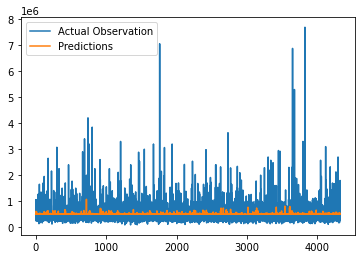

In [76]:
test_model(model2, test, features)

AxesSubplot(0.125,0.125;0.775x0.755)


,Actual Observation,Predictions
0,459000,525383.6250
1,445000,524776.0625
2,1057000,750995.5000
3,732350,527212.3750
4,235000,528302.0625
...,...,...
4318,965000,528598.4375
4319,359950,524160.4375
4320,260000,526721.8125
4321,1795000,538694.5625


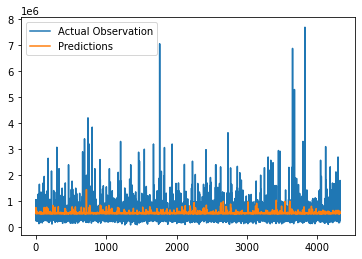

In [77]:
test_model(model3, test, advanced_features)

## Sources
[Introductory Guide to PyTorch Using a Linear Regression Problem](https://analyticsindiamag.com/introductory-guide-to-pytorch-using-a-linear-regression-problem/)

[Linear Regression and Gradient Descent in PyTorch](https://www.analyticsvidhya.com/blog/2021/08/linear-regression-and-gradient-descent-in-pytorch/)

[Interesting Ways to Select Pandas DataFrame Columns](https://towardsdatascience.com/interesting-ways-to-select-pandas-dataframe-columns-b29b82bbfb33#:~:text=This%20is%20the%20most%20basic,Returns%20a%20pandas%20series.&text=Passing%20a%20list%20in%20the,columns%20at%20the%20same%20time.)